In [152]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from scipy.stats import uniform
from sklearn.model_selection import RandomizedSearchCV

In [67]:
#Import the Non-League football CSV file containing teams, their league position, their promotion status and their twitter followers
football = pd.read_csv("football_data_final_edit.csv")
#Drop null rows which erroneously came with the CSV 
football.drop([0,1], inplace=True)
#Drop null columns which erroneously came with the CSV
football.drop(["Unnamed: 25","Unnamed: 26","Unnamed: 27","Unnamed: 28"],inplace=True,axis=1)
#Since we dropped some rows, we need to reset the index of the dataframe
football = football.reset_index(drop=True)
#The column headings came from the CSV as the first row, redefine the headings correctly and strip any whitespace with lambda func
strip_whitespace = lambda x: x.strip() 
column_headings = list(map(strip_whitespace,list(football.iloc[0])))
football.columns = column_headings
#Remove the now un-needed dupiclate row containing the column headings and reset the index again.
football.drop(football[football["Step"]=="0"].index,inplace=True)
football.drop([0],inplace=True)
football = football.reset_index(drop=True)
#Let's trim any whitespace from entries and column headings
football =football.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

football.dropna(subset =["Step","League","Gained between 19/4/23 & 29/6/22","2021-22\nPosition","2022-23\nPosition","29.06.22","19.04.23"],how="any",inplace=True)




In [68]:
#For loop to determine whether team improved on their ranking from last season. 2021/22 - 2022/23
positional_improvement = []
for i in range(0,len(football)):
    if float(football.iloc[i]["2022-23\nPosition"]) < float(football.iloc[i]["2021-22\nPosition"]):
        if float(football.iloc[i]["2021-22 Promoted"]) == 1:
            positional_improvement.append(1)
        elif float(football.iloc[i]["2021-22 Promoted"]) == 2:
            positional_improvement.append(1)
        else: 
            positional_improvement.append(0)
    else:
        if float(football.iloc[i]["2021-22 Promoted"]) == 2: 
            positional_improvement.append(1)
        else:
            positional_improvement.append(0)
#Set this created list to be the new column "Positional Improvement"
football["Positional Improvement"] = positional_improvement

In [103]:
#Drop rows which are step 0 as these aren't non-league teams.
football = football.sort_values(by=["Step"])
#Sort values in dataframe by the step, then drop NaN values from league and step as these are not compatible with later analysis
football.dropna(subset =["Step","League","Gained between 19/4/23 & 29/6/22"],how="any",inplace=True)
#Reset the index based on the sorted table
football = football.reset_index(drop=True)
#Remove commas from dataframe values
football = football.replace(",","",regex=True)
pd.set_option('display.max_columns', None)

football_follower_count = football[["06.12.18","17.01.19","26.03.19","12.02.20","03.06.20","20.09.20","10.10.20","18.11.20","03.02.21","04.04.21","22.01.22","27.05.22","29.06.22","06.10.22","18.12.22","19.04.23","15.07.23"]]
football_follower_count.astype("float64")
for col in football_follower_count:
    football_follower_count[col] = pd.to_numeric(football_follower_count[col],errors="ignore")
football_follower_count = football_follower_count.interpolate(method="linear",axis=1,limit_direction="backward")
football[["06.12.18","17.01.19","26.03.19","12.02.20","03.06.20","20.09.20","10.10.20","18.11.20","03.02.21","04.04.21","22.01.22","27.05.22","29.06.22","06.10.22","18.12.22","19.04.23","15.07.23"]] = football_follower_count


C:\Users\seb_d\AppData\Local\Temp/ipykernel_4060/2831722356.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  football_follower_count[col] = pd.to_numeric(football_follower_count[col],errors="ignore")


,Step,League,2021-22\nPosition,2021-22 Promoted,2022-23\nPosition,2022-23 Promoted,Teams,06.12.18,17.01.19,26.03.19,12.02.20,03.06.20,20.09.20,10.10.20,18.11.20,03.02.21,04.04.21,22.01.22,27.05.22,29.06.22,06.10.22,18.12.22,19.04.23,15.07.23,Gained between 19/4/23 & 29/6/22,Positional Improvement
0,1,National League,15,1,4,1,Woking,16328.0,16948.0,17471.0,19495.0,19700.0,19953.0,20225.000000,20496.000000,20791.000000,21065.000000,22526.0,23403.0,23589.0,24308.0,24970.0,26117.0,26546.0,2528,1
1,1,National League,20,1,18,1,Aldershot Town,35129.0,35317.0,35481.0,37028.0,36900.0,37198.0,37274.000000,37390.000000,37760.000000,37892.000000,39369.0,40105.0,40330.0,41004.0,41402.0,42451.0,42770.0,2121,1
2,1,National League,7,1,3,1,Chesterfield,76096.0,76699.0,77155.0,78754.0,78400.0,78336.0,78529.000000,78630.000000,79097.000000,79373.000000,88210.0,93297.0,93808.0,95478.0,96412.0,98105.0,99776.0,4297,1
3,1,National League,4,1,11,1,FC Halifax Town,27795.0,27990.0,28182.0,29814.0,29900.0,30462.0,30531.000000,30672.000000,31200.000000,31577.000000,33402.0,34763.0,35007.0,35859.0,36232.0,37191.0,37571.0,2184,0
4,1,National League,17,1,20,1,Maidenhead United,9784.0,9957.0,10207.0,11999.0,12100.0,12421.0,12529.000000,12677.000000,12840.000000,13007.000000,14266.0,14860.0,14973.0,15422.0,15678.0,16064.0,16347.0,1091,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
919,6,Northern Counties East League Div. One,15,1,18,1,Shirebrook Town,3770.0,3770.0,3770.0,4122.0,4129.0,4218.0,4241.333333,4264.666667,4288.000000,4418.000000,4548.0,4630.0,4712.0,4737.0,4762.0,4997.0,5225.0,285,0
920,6,Northern Counties East League Div. One,14,1,12,1,Nostell Miners Welfare,2033.0,2033.0,2033.0,2365.0,2417.0,2567.0,2614.666667,2662.333333,2710.000000,2859.000000,3008.0,3091.5,3175.0,3206.5,3238.0,3355.0,3378.0,180,1
921,6,Southern Combination League Div. One,13,1,12,1,Mile Oak,2275.0,2275.0,2275.0,2678.0,2719.0,2867.0,2880.666667,2894.333333,2908.000000,3030.000000,3152.0,3253.5,3355.0,3410.5,3466.0,3526.0,3576.0,171,1
922,6,Midland Football League Div. One,14,1,20,1,AFC Bridgnorth,2086.0,2086.0,2086.0,2291.0,2413.0,2745.0,2795.333333,2845.666667,2896.000000,3040.000000,3184.0,3274.0,3364.0,3412.0,3460.0,3561.0,3664.0,197,0


In [104]:
#Turn our features and targets into int64's.
football["Gained between 19/4/23 & 29/6/22"] = football["Gained between 19/4/23 & 29/6/22"].apply(pd.to_numeric)
football["2022-23 Promoted"] = football["2022-23 Promoted"].apply(pd.to_numeric)
#Define features as x and targets as y. 
x = np.array(football["Gained between 19/4/23 & 29/6/22"]).reshape(-1,1)
y = np.array(football["Positional Improvement"])
#Perform a train test split, 80% train and 20% test
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2)

In [165]:
pipeline = Pipeline([("transform",StandardScaler()),("classifier",SVC(max_iter = 10000))])

pipeline.fit(x_train,y_train)
pipeline.predict(x_test)
print(pipeline.score(x_test,y_test))
np.unique(y_test,return_counts=True)
#Now have altered the model such that the features remain as the gained twitter followers but the labels are now "positional improvement".
#Next we will tune the hyperperameters and use things like gridsearch to improve our score. 
distributions = {'kernel': ['linear','poly','rbf'], 'C': uniform(loc=0, scale=100),"gamma":uniform(loc=0,scale=100)}
clf = RandomizedSearchCV(SVC(max_iter=10000), distributions, n_iter=20)
clf.fit(x_train,y_train)
print(clf.best_estimator_)
clf.cv_results_['mean_test_score']

0.5891891891891892


C:\Users\seb_d\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  # In binary case, we need to flip the sign of coef, intercept and
C:\Users\seb_d\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  # In binary case, we need to flip the sign of coef, intercept and
C:\Users\seb_d\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  # In binary case, we need to flip the sign of coef, intercept and
C:\Users\seb_d\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler o

C:\Users\seb_d\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  # In binary case, we need to flip the sign of coef, intercept and
C:\Users\seb_d\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  # In binary case, we need to flip the sign of coef, intercept and
C:\Users\seb_d\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  # In binary case, we need to flip the sign of coef, intercept and
C:\Users\seb_d\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler o

C:\Users\seb_d\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  # In binary case, we need to flip the sign of coef, intercept and
C:\Users\seb_d\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  # In binary case, we need to flip the sign of coef, intercept and
C:\Users\seb_d\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  # In binary case, we need to flip the sign of coef, intercept and


SVC(C=20.081231054638103, gamma=75.32499485778999, kernel='poly',
    max_iter=10000)


C:\Users\seb_d\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  # In binary case, we need to flip the sign of coef, intercept and


array([0.51826623, 0.51826623, 0.50602133, 0.51823865, 0.50196727,
       0.50196727, 0.51823865, 0.51823865, 0.51823865, 0.50196727,
       0.50196727, 0.51826623, 0.51826623, 0.50602133, 0.5114635 ,
       0.50196727, 0.50196727, 0.51826623, 0.51823865, 0.51823865])

In [150]:
sfs = SFS(LinearSVC(max_iter=10000),
           k_features=3, # number of features to select
           forward=True,
           floating=False,
           scoring='accuracy',
           cv=5)
x_num=football[["2021-22\nPosition","2021-22 Promoted","06.12.18","17.01.19","26.03.19","12.02.20","03.06.20","20.09.20","10.10.20","18.11.20","03.02.21","04.04.21","22.01.22","27.05.22","29.06.22","06.10.22","18.12.22","19.04.23","15.07.23"]]
sfs.fit(x_num,
        football["Positional Improvement"])
print(sfs.subsets_)


C:\Users\seb_d\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  -------
C:\Users\seb_d\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  -------
C:\Users\seb_d\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  -------
C:\Users\seb_d\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  -------
C:\Users\seb_d\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  -------
C:\Users\seb_d\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  -------
C:\Users\seb_d\a

C:\Users\seb_d\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  -------
C:\Users\seb_d\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  -------
C:\Users\seb_d\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  -------
C:\Users\seb_d\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  -------
C:\Users\seb_d\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  -------
C:\Users\seb_d\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  -------
C:\Users\seb_d\a

C:\Users\seb_d\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  -------
C:\Users\seb_d\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  -------
C:\Users\seb_d\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  -------
C:\Users\seb_d\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  -------
C:\Users\seb_d\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  -------
C:\Users\seb_d\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  -------
C:\Users\seb_d\a

C:\Users\seb_d\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  -------
C:\Users\seb_d\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  -------
C:\Users\seb_d\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  -------
C:\Users\seb_d\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  -------
C:\Users\seb_d\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  -------
C:\Users\seb_d\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  -------
C:\Users\seb_d\a

C:\Users\seb_d\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  -------
C:\Users\seb_d\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  -------
C:\Users\seb_d\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  -------
C:\Users\seb_d\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  -------
C:\Users\seb_d\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  -------
C:\Users\seb_d\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  -------
C:\Users\seb_d\a

C:\Users\seb_d\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  -------
C:\Users\seb_d\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  -------
C:\Users\seb_d\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  -------
C:\Users\seb_d\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  -------
C:\Users\seb_d\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  -------
C:\Users\seb_d\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  -------
C:\Users\seb_d\a

{1: {'feature_idx': (1,), 'cv_scores': array([0.57837838, 0.60540541, 0.5027027 , 0.6       , 0.5923913 ]), 'avg_score': 0.5757755581668624, 'feature_names': ('2021-22 Promoted',)}, 2: {'feature_idx': (0, 1), 'cv_scores': array([0.62702703, 0.64324324, 0.62162162, 0.6972973 , 0.69565217]), 'avg_score': 0.6569682726204464, 'feature_names': ('2021-22\nPosition', '2021-22 Promoted')}, 3: {'feature_idx': (0, 1, 2), 'cv_scores': array([0.54054054, 0.53513514, 0.47027027, 0.52432432, 0.55434783]), 'avg_score': 0.5249236192714454, 'feature_names': ('2021-22\nPosition', '2021-22 Promoted', '06.12.18')}}


C:\Users\seb_d\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  -------


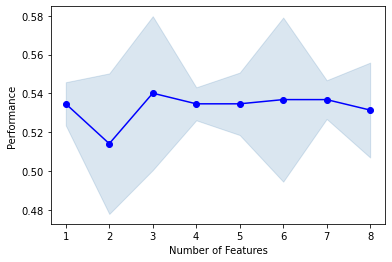

In [116]:
plot_sfs(sfs.get_metric_dict())
plt.show()